In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random 
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import Logger
from stable_baselines3.common.evaluation import evaluate_policy
import json

import warnings
warnings.filterwarnings("ignore")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
from lib.DynamicPricing.DynamicPricingEnv import *
from lib.DynamicPricing.DynamicPricingEnvEval import *

from lib.utils.revenue_weights import calculate_revenue_weights
from lib.DynamicPricing.utils.feature_importance import feature_importance_shap
from lib.DynamicPricing.utils.plots import plot_market_metrics
from lib.DynamicPricing.utils.eval_runner import run_evaluation

In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [5]:
df = pd.read_csv('walmart_dynamic_pricing.csv')
df["yhat_sold"] = df["yhat_sold"].clip(lower=0)

In [6]:
calculate_revenue_weights(df)

Saved: lib/configs/revenue_weights.json


In [7]:
weights = RevenueWeights.from_json("./lib/configs/revenue_weights.json", default_weight=1.0, normalize=True)

In [8]:
df.describe()

,customer_segment,sell_price,sold,revenue,avg_price_last_week,avg_price_last_month,yhat_sold,yhat_revenue
count,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000,54264.000000
mean,1.500000,4.281196,1231.737616,4712.124897,4.281042,4.280455,1231.859242,4712.265223
std,1.118044,1.320143,1444.761240,4295.429329,1.320064,1.319761,1397.654292,4118.060670
min,0.000000,2.580000,0.000000,0.000000,2.580000,2.580000,0.000000,-1305.714706
25%,0.750000,2.890000,389.000000,1869.160000,2.890000,2.890000,415.139291,1983.460354
50%,1.500000,4.090000,736.000000,3347.270000,4.090000,4.088333,757.355693,3417.776289
75%,2.250000,5.380000,1349.000000,6451.640000,5.380000,5.374083,1315.469258,6502.587415
max,3.000000,6.650000,10535.000000,29498.000000,6.650000,6.650000,9778.636273,27666.289120


# Training

## Env to training

In [9]:
# Create env factory for DummyVecEnv
def make_env():
    env = DynamicPricingEnv(
        df=df,
        start_date="2011-02-01",
        end_date="2014-12-31",
        eval_start="2015-01-01",
        eval_end="2016-04-30",
        mode="train",
        price_change_limit = 0.2,
        price_elasticity = -1.25,
        revenue_weights=weights,
        seed=SEED,
        penalty=0.0,                 
        stochastic_elasticity=True, 
        render_mode=None
    )
    return Monitor(env)

# Vectorized env (required by SB3)
train_env = DummyVecEnv([make_env])

train_env = VecNormalize(
    train_env, 
    norm_obs=True,     # Normalizuje obserwacje (ceny, daty)
    norm_reward=True,  # Normalizuje nagrodę (z 5000 robi np. 1.5)
    clip_obs=10.,      # Ucina wartości skrajne
    gamma=0.99
)

## PPO model

In [10]:
policy_kwargs = dict(net_arch=dict(pi=[256, 256], vf=[256, 256]))

# PPO model
model = PPO(
    policy="MlpPolicy",
    env=train_env,
    policy_kwargs=policy_kwargs,
    verbose=1,
    tensorboard_log="./lib/logs/PPO/",
    n_steps=1024,
    batch_size=64,
    gamma=0.99,
    learning_rate=3e-4,
    ent_coef=0.05,
    seed=SEED
)

# Train
model.learn(total_timesteps=2_000_000, progress_bar=False)

model.save("ppo_pricing_model")
train_env.save("vec_normalize.pkl") 
print("Model and statistics of normalization has been saved.")

Using cpu device
Logging to ./lib/logs/PPO/PPO_33
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 223      |
|    ep_rew_mean     | -514     |
| time/              |          |
|    fps             | 1446     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 549          |
|    ep_rew_mean          | -3.96e+03    |
| time/                   |              |
|    fps                  | 1115         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0078621805 |
|    clip_fraction        | 0.0672       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    exp

To see the training open terminal and paste:

tensorboard --logdir ./lib/logs/PPO/ --host 0.0.0.0

In [11]:
# Quick evaluation on the same env (pipeline check)
mean_reward, std_reward = evaluate_policy(model, train_env, n_eval_episodes=20, deterministic=True)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Mean reward: -145.17 +/- 2137.26


# Evaluation

In [12]:
def make_eval_env():
    return DynamicPricingEnvEval(
        df=df,
        start_date="2012-02-01",
        end_date="2014-12-31",
        eval_start="2015-01-01",
        eval_end="2016-12-31",
        revenue_weights=weights,
        seed=42,
        render_mode="human",
        penalty=0.0,        
        stochastic_elasticity=False
)
eval_env = DummyVecEnv([make_eval_env])

In [13]:
try:
    eval_env = VecNormalize.load("vec_normalize.pkl", eval_env)
except FileNotFoundError:
    print("BŁĄD: Nie znaleziono pliku vec_normalize.pkl. Model nie zadziała poprawnie!")

eval_env.training = False      
eval_env.norm_reward = False

In [14]:
results_df = run_evaluation(eval_env, model)

Starting evaluation for 28 combinations...
Evaluation finished. Plots saved to ./plots/


## Plots

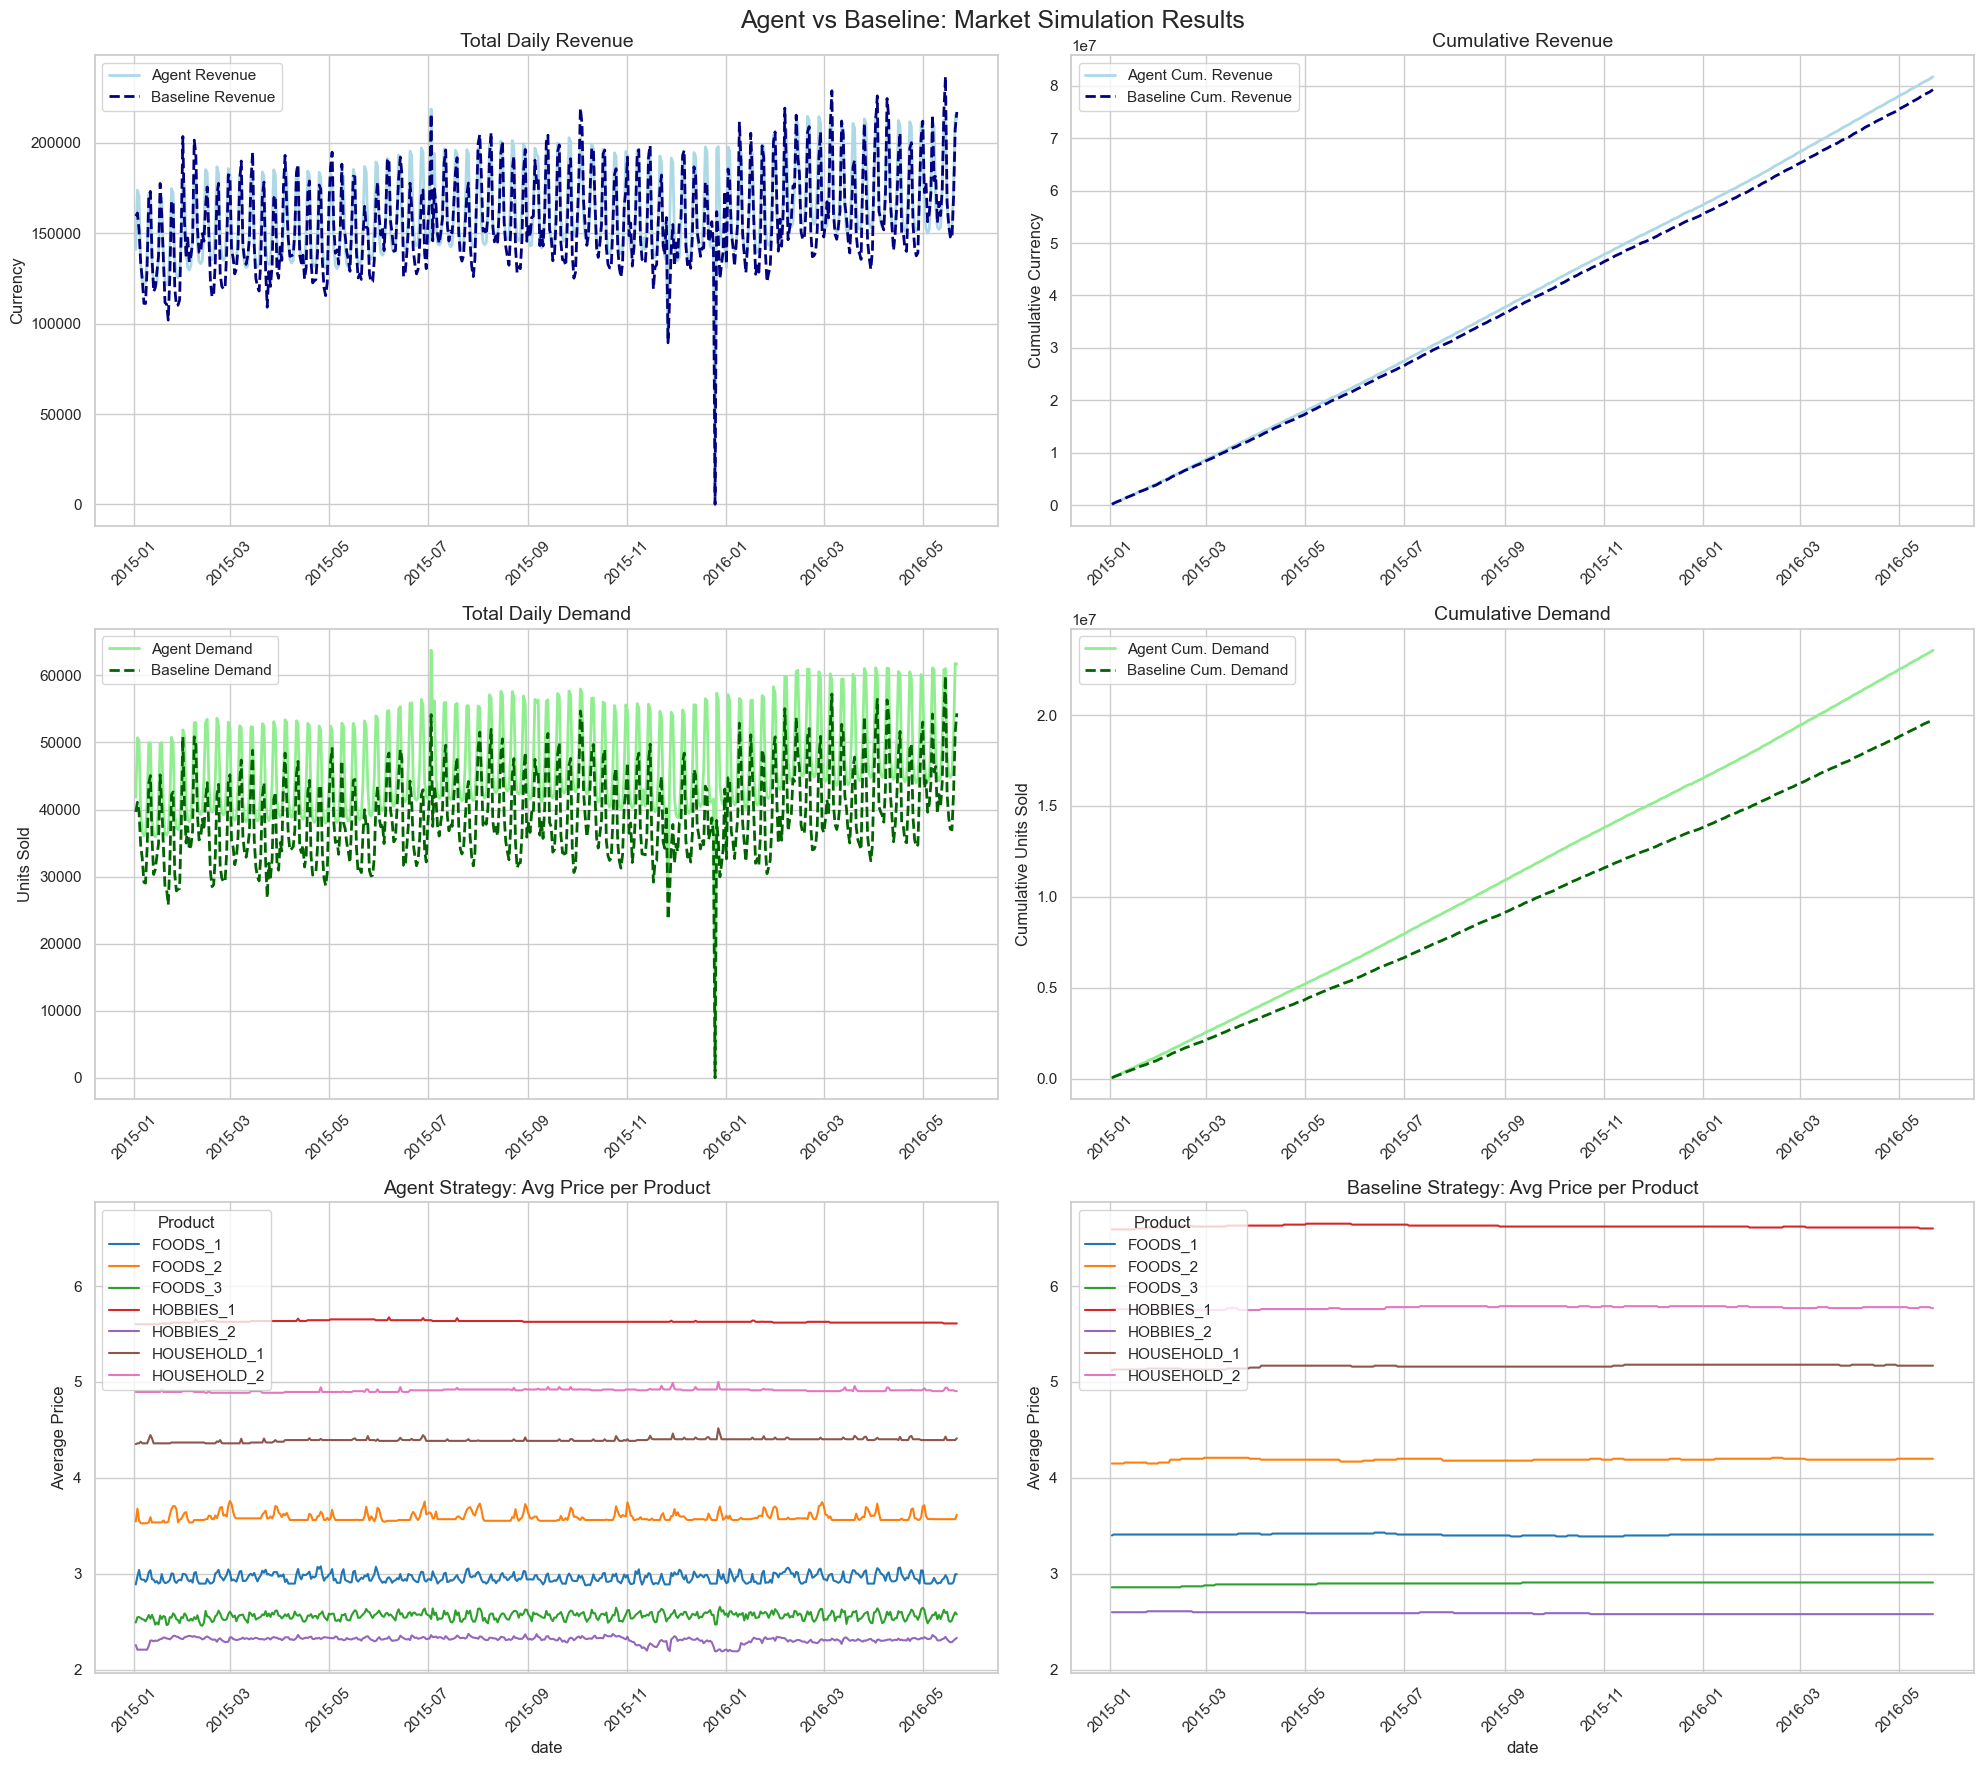

In [15]:
plot_market_metrics(results_df, df)

## Results

In [16]:
results_df['date'].min(), results_df['date'].max()

(Timestamp('2015-01-02 00:00:00'), Timestamp('2016-05-22 00:00:00'))

In [17]:
df_r = df.query("date >= '2015-01-02' & date <= '2016-05-22' ")
df_r['date'].min(), df_r['date'].max()

('2015-01-02', '2016-05-22')

In [18]:
agent = results_df['revenue'].sum()
base = df_r['revenue'].sum()

In [19]:
agent, base

(np.float64(81726928.51682235), np.float64(79254065.16))

In [20]:
((agent/base)-1)*100

np.float64(3.120172260981291)

## Feature importance

In [21]:
cols = eval_env.get_attr("feature_cols")[0]

Calculating SHAP values (this may take a while)...


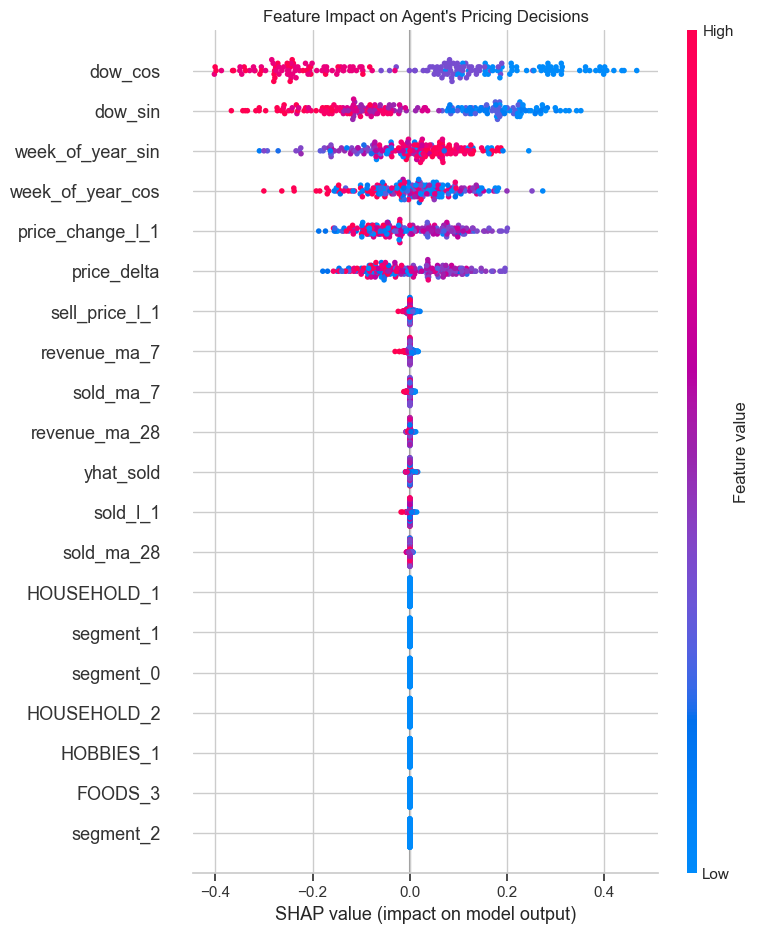

In [22]:
feature_importance_shap(model, eval_env, cols)